# Topic:- Unsupervised Representation Learning With DCGANs for Precision Agriculture
## Name:- Yadnesh Mankame
## Student Id:- L00179080
## Masters in Data Science
## Supervised by: Dr. Shagufta Henna

In [ ]:
# Cheeck the GPU type

!nvidia-smi

Wed Jul 24 19:21:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:

%matplotlib inline
# Visualization
from matplotlib import pyplot as plt

from matplotlib.image import imread

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# To search for files that match a specific file pattern or name
import glob

# Resize the image
import cv2
import os
import PIL
import time

from IPython import display

In [ ]:
tf.__version__

'2.15.0'

## Mount the google drive to save Kaggle API credentials for further use

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Show the files in the directory

In [ ]:
# Use os module to list all the files in the directory
import os

os.listdir('/content/drive/MyDrive/Colab Notebooks/Dissertation/dataset')

['soybean', 'grass', 'broadleaf', 'soil']

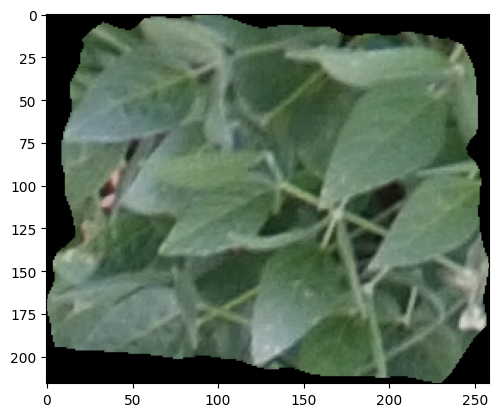

In [ ]:

## Display the images for the example
path = '/content/drive/MyDrive/Colab Notebooks/Dissertation/dataset/'

image = imread(path+'soybean/1583.tif')
plt.imshow(image)
plt.show()

# Deep Convolutional GAN (DCGAN)

### Goal
In this notebook, we're going to create another GAN using the weed dataset. Implement a Deep Convolutional GAN (DCGAN)





## Getting Started

#### DCGAN
Here are the main features of DCGAN :



*   Using convolutions without any pooling layers
*   Using batchnorm in both the generator and the discriminator
*   Ignored fully connected hidden layers
*   Used ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Used LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation



In [ ]:
# Importing necessary libraries and modules from PyTorch, tqdm, torchvision, and matplotlib
import torch
from torch import nn  # Importing the neural network module from PyTorch
from tqdm.auto import tqdm  # Importing tqdm for displaying progress bars in loops
from torchvision import transforms  # Importing transformations for image preprocessing
from torchvision.utils import make_grid  # Importing utility for creating a grid of images
from torch.utils.data import DataLoader  # Importing DataLoader for batch loading of datasets
import matplotlib.pyplot as plt  # Importing matplotlib for plotting and visualization

torch.manual_seed(0) # Set for testing purposes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()  # Move to CPU before converting to NumPy
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator



In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
                 (default is 3 channels for RGB images)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                         (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_noise(n_samples, z_dim, device=device):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

# Example usage
z_dim = 64
gen = Generator(z_dim=z_dim, im_chan=3).to(device)
fake_noise = get_noise(128, z_dim, device=device)
fake = gen(fake_noise)
print(fake.detach().shape)  # Should print torch.Size([128, 3, 28, 28])


torch.Size([128, 3, 28, 28])


In [ ]:
# Initialize the Generator and move it to the specified device (GPU or CPU)
gen = Generator().to(device)

# Number of test samples to generate
num_test = 100

# Test the hidden block
# Generate noise for testing the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim, device=device)

# Create a hidden generator block with specific input and output channels, kernel size, and stride, and move it to the device
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1).to(device)  # Move to device

# Reshape the noise to the appropriate dimensions for the generator
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)

# Pass the reshaped noise through the hidden generator block
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
# Create another hidden generator block with a different stride
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

# Generate final noise for testing the final block
test_final_noise = get_noise(num_test, gen.z_dim) * 20

# Create the final generator block and move it to the device
test_final_block = gen.make_gen_block(10, 20, final_layer=True).to(device)  # Move to device

# Reshape the final noise to the appropriate dimensions for the generator
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)

# Pass the reshaped noise through the final generator block
final_output = test_final_block(test_final_uns_noise)

# Test the whole Generator network:
# Generate noise for testing the whole generator
test_gen_noise = get_noise(num_test, gen.z_dim, device=device)

# Reshape the generated noise
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)

# Pass the reshaped noise through the entire generator network to produce images
gen_output = gen(test_uns_gen_noise)


## Discriminator


In [ ]:

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, hidden_dim=16):
      super(Discriminator, self).__init__()
      self.disc = nn.Sequential(
          self.make_disc_block(im_chan, hidden_dim, kernel_size=4, stride=2, padding=1),
          self.make_disc_block(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
          self.make_disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
          self.make_disc_block(hidden_dim * 4, 1, kernel_size=4, stride=2, padding=1, final_layer=True),
      )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

# Example usage
disc = Discriminator(im_chan=3).to(device)



In [ ]:

num_test = 100

gen = Generator().to(device)
disc = Discriminator().to(device)
print(gen.z_dim)
test_images = gen(get_noise(num_test, gen.z_dim, device=device))

# Test the hidden block
test_hidden_block = disc.make_disc_block(3, 5, kernel_size=4, stride=2, padding=1).to(device)
test_images = torch.randn(100, 3, 28, 28).to(device)  # Ensure test images have 3 channels and are on the same device as the model
hidden_output = test_hidden_block(test_images)
print(hidden_output.shape)

# Test the final block
test_final_block = disc.make_disc_block(3, 10, kernel_size=4, stride=2, padding=1, final_layer=True).to(device)
final_output = test_final_block(test_images)
print(final_output.shape)

# Test the whole thing:
disc_output = disc(test_images)
print(disc_output.shape)



10
torch.Size([100, 5, 14, 14])
torch.Size([100, 10, 14, 14])
torch.Size([100, 1])


Here's a test for your discriminator block:

In [ ]:
# Calculate expected shape after convolution
expected_hidden_shape = (num_test, 5, 14, 14)  # Adjust this based on calculations
assert tuple(hidden_output.shape) == expected_hidden_shape, f"Expected shape: {expected_hidden_shape}, but got: {tuple(hidden_output.shape)}"

# Check the hidden block activations
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block
test_final_block = disc.make_disc_block(3, 10, kernel_size=2, stride=5, final_layer=True).to(device)
final_output = test_final_block(test_images)
print("Final block output shape:", final_output.shape)  # Print the shape for debugging

# Calculate expected shape after final block convolution
expected_final_shape = (num_test, 10, 6, 6)  # Adjust this based on calculations
assert tuple(final_output.shape) == expected_final_shape, f"Expected shape: {expected_final_shape}, but got: {tuple(final_output.shape)}"

# Check the final block activations
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole discriminator
disc_output = disc(test_images)
print("Discriminator output shape:", disc_output.shape)  # Print the shape for debugging

# Calculate expected shape after the whole discriminator
expected_disc_shape = (num_test, 1)
assert tuple(disc_output.shape) == expected_disc_shape, f"Expected shape: {expected_disc_shape}, but got: {tuple(disc_output.shape)}"

# assert disc_output.std() > 0.25
# assert disc_output.std() < 0.5
print("Success!")

Final block output shape: torch.Size([100, 10, 6, 6])
Discriminator output shape: torch.Size([100, 1])
Success!


## Training on the data
Now you can put it all together!
Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

<!-- In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.  -->


In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define the list of labels
labels = ["broadleaf", "grass", "soil", "soybean"]

# Parameters
image_size = (224, 224)  # Adjust to match VGG16 input size
batch_size = 128

# Convert labels to numerical values using index number according to the list
label_to_index = {label: index for index, label in enumerate(labels)}

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),      # 1. Convert the input image (e.g., from OpenCV) to a PIL Image format.
    transforms.Resize(image_size),  # 2. Resize the image to the desired size (specified by image_size).
    transforms.ToTensor(),         # 3. Convert the PIL Image into a PyTorch tensor.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Custom dataset class
class WeedDataset(Dataset):
    def __init__(self, labels, label_to_index, transform=None):
        self.labels = labels
        self.label_to_index = label_to_index
        self.transform = transform
        self.image_paths = []
        self.image_labels = []

        # Load dataset
        for label in labels:
            dataset_path = "/content/drive/MyDrive/Colab Notebooks/Dissertation/dataset/" + label + "/"
            file_paths = glob.glob(dataset_path + "*")
            for file_path in file_paths:
                self.image_paths.append(file_path)
                self.image_labels.append(label_to_index[label])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.image_labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        if self.transform:
            image = self.transform(image)


         # Convert label to a tensor
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Create dataset and dataloader
dataset = WeedDataset(labels, label_to_index, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Check if data loading works correctly
dataiter = iter(dataloader)
images, labels = next(dataiter)
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch of images shape: torch.Size([128, 3, 224, 224])
Batch of labels shape: torch.Size([128])


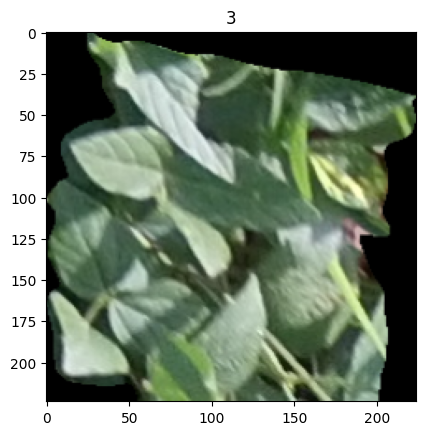

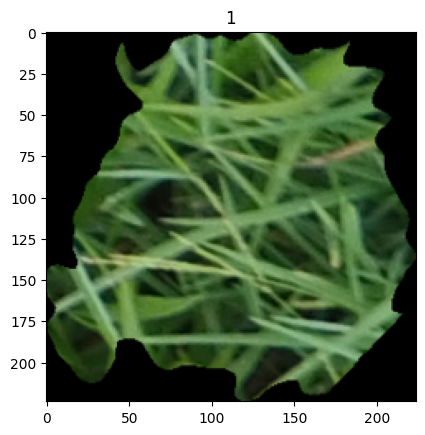

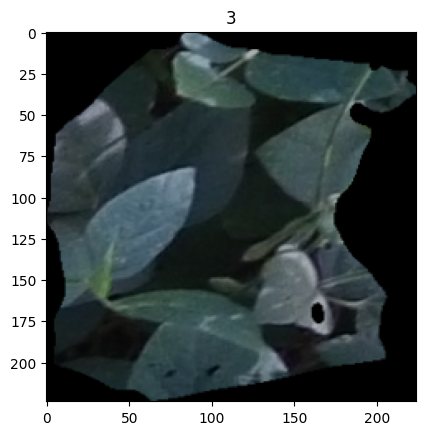

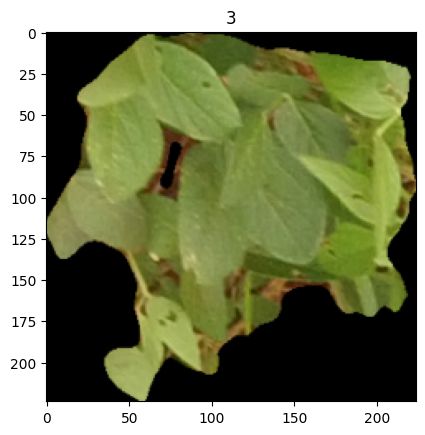

In [ ]:
# Function to denormalize and display images
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# Display the first 4 images in the batch
for i in range(4):
    imshow(images[i], title=labels[i].item())

In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])



## Initialize your generator, discriminator, and optimizers.

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)



# Function to generate images using the trained generator
def generate_images(gen, n_images, z_dim, device='cpu'):
    gen.eval()
    noise = get_noise(n_images, z_dim, device=device)
    with torch.no_grad():
        fake_images = gen(noise).detach().cpu()
    return fake_images



## Train GAN

In [ ]:
images.shape

torch.Size([128, 3, 224, 224])

In [ ]:
import torch.nn.functional as F
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim, kernel_size=4, stride=2, padding=1),
            self.make_disc_block(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            self.make_disc_block(hidden_dim * 4, 1, kernel_size=4, stride=2, padding=1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)
            )

    def forward(self, image):
        x = self.disc(image)
        # print(f"Discriminator conv output shape: {x.shape}")  # Debug print
        x = x.view(len(x), -1)  # Flatten the output
        # print(f"Discriminator flattened shape: {x.shape}")  # Debug print
        return x

# Initialize generator and discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 64
gen = Generator(z_dim=z_dim, im_chan=3).to(device)
disc = Discriminator(im_chan=3).to(device)

# Check if data loading works correctly
dataiter = iter(dataloader)
images, labels = next(dataiter)
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)


Batch of images shape: torch.Size([128, 3, 224, 224])
Batch of labels shape: torch.Size([128])


## Generator and Discriminator Summary

In [ ]:
print(gen)



Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)


In [ ]:
from torchsummary import summary
summary(gen, (z_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 3, 28, 28]           3,075
             Tanh-11            [-1, 3, 28, 28]               0
Total params: 749,891
Trainable params: 749,891
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
summary(disc, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             784
       BatchNorm2d-2           [-1, 16, 14, 14]              32
         LeakyReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           8,224
       BatchNorm2d-5             [-1, 32, 7, 7]              64
         LeakyReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 3, 3]          32,832
       BatchNorm2d-8             [-1, 64, 3, 3]             128
         LeakyReLU-9             [-1, 64, 3, 3]               0
           Conv2d-10              [-1, 1, 1, 1]           1,025
Total params: 43,089
Trainable params: 43,089
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.16
Estimated Tot

In [ ]:
print(disc)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  )
)


In [ ]:

# Forward pass through the discriminator
disc_real_pred = disc(images.cuda())
# print("Discriminator output shape:", disc_real_pred.shape)

  0%|          | 0/116 [00:00<?, ?it/s]

Step 30: Generator loss: 0.6424539347489674, discriminator loss: 0.7098805904388427


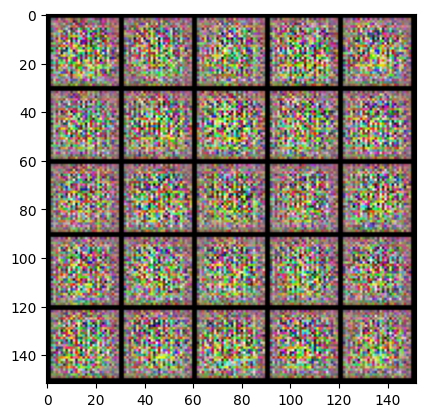

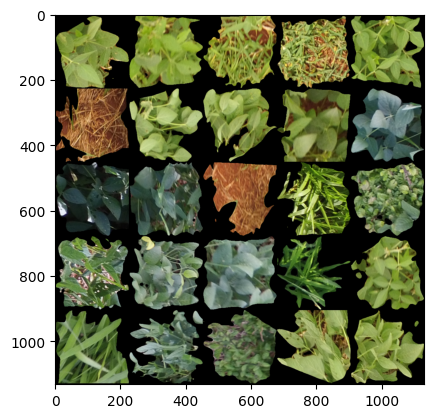

Step 60: Generator loss: 0.6223554293314616, discriminator loss: 0.6863782624403636


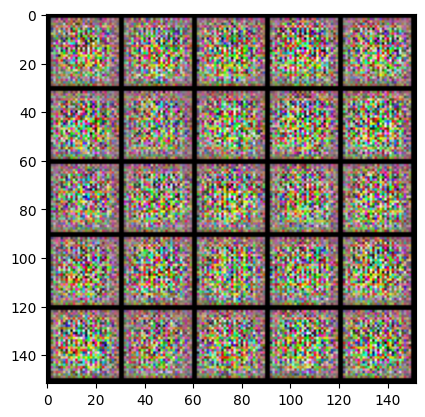

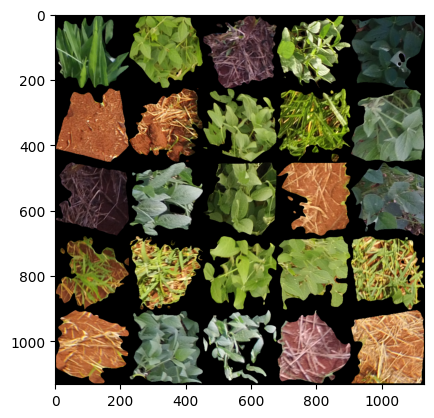

Step 90: Generator loss: 0.6225920538107552, discriminator loss: 0.6861628313859305


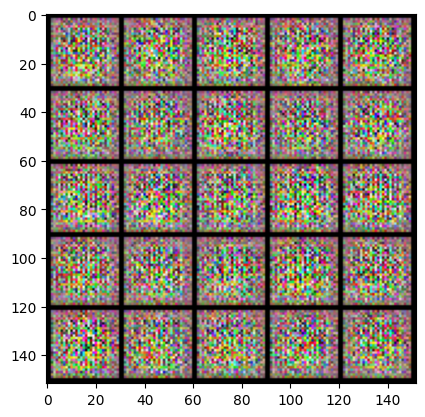

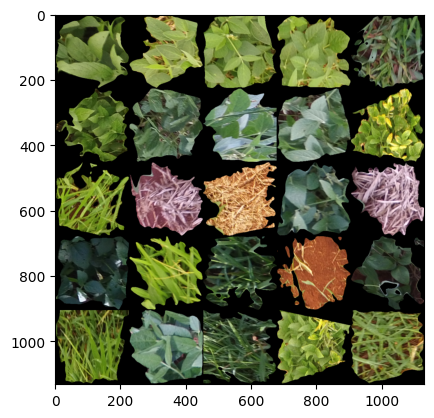

In [ ]:
from torch.utils.data import ConcatDataset, TensorDataset
from torchvision.transforms import Resize

n_epochs = 1
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
display_step = 30
batch_size = 130


g_loss = []
d_loss = []


# Lists to Store Fake Images and Labels
fake_images = []
fake_labels = []  # Assuming you want to assign a label to fake images

for epoch in range(n_epochs):
    # Loop over each batch returned by the dataloader
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        # Zero the gradients of the discriminator optimizer
        disc_opt.zero_grad()

        # Generate fake images using the generator
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        fake_images.append(fake.cpu())  # Move fake images to CPU for storage

        # Create fake labels with the correct shape
        fake_labels.append(torch.zeros(fake.shape[0], dtype=torch.long))  # Create the same shape as fake

        # Calculate discriminator loss on fake images
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        # Calculate discriminator loss on real images
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        # Calculate total discriminator loss
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Backpropagate and update discriminator weights
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Store discriminator loss
        d_loss.append(mean_discriminator_loss)

        ## Update generator ##
        # Zero the gradients of the generator optimizer
        gen_opt.zero_grad()

        # Generate fake images again
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)

        # Calculate generator loss
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        # Backpropagate and update generator weights
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        g_loss.append(mean_generator_loss)

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            # Print generator and discriminator losses
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)

            # Reset the mean losses for the next display step
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

    # Resize Fake Images and Create Augmented Dataset
    # Resize fake images to match the input size expected by the model
    fake_images_resized = [Resize((224, 224))(img) for img in fake_images]

    # Combine resized fake images into a single tensor
    fake_images_tensor = torch.cat(fake_images_resized, dim=0)

    # Combine fake labels into a single tensor
    fake_labels_tensor = torch.cat(fake_labels, dim=0)

    # Create an augmented dataset with fake images and labels
    augmented_dataset = TensorDataset(fake_images_tensor, fake_labels_tensor)

    # Combine the original dataset with the augmented dataset
    combined_dataset = ConcatDataset([dataset, augmented_dataset])

    # Create a new dataloader with the combined dataset
    dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

    # Clear the fake images and labels list for the next epoch
    fake_images = []
    fake_labels = []



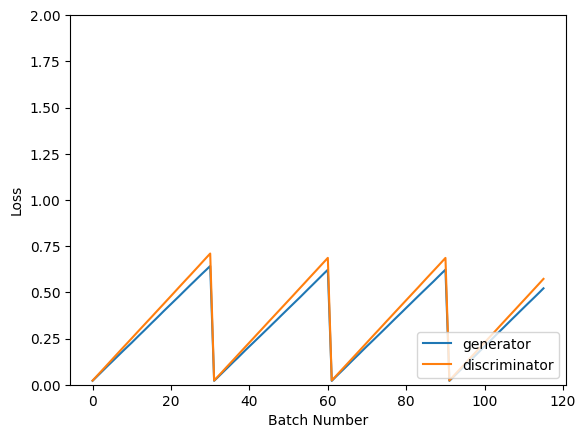

In [ ]:
plt.figure()
plt.plot(g_loss, label='generator')
plt.plot(d_loss, label = 'discriminator')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')
plt.show()

# Steps to apply CNN

## Split the dataloader into X and y

In [ ]:
dataiter = iter(dataloader)
images, labels = next(dataiter)
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)

Batch of images shape: torch.Size([130, 3, 224, 224])
Batch of labels shape: torch.Size([130])


In [ ]:
X = []  # List to store images
y = []  # List to store labels

# Define resize transformation
resize_transform = transforms.Resize((28, 28))  # Target size

for images, labels in dataloader:


   # Resize images on the CPU (before moving to device)
    images_resized = torch.stack([resize_transform(img) for img in images])

    images = images_resized.to(device)  # Move images to the device (GPU)
    labels = labels.to(device)

    # Append data to the lists
    X.append(images)
    y.append(labels)

# Stack the lists into tensors
X = torch.cat(X, dim=0)
y = torch.cat(y, dim=0)

In [ ]:
# Splitting into Training and Testing Sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test


In [ ]:
print(f"Test Shape before {X_train.shape}\nTest Shape after {X_test.shape}")
print(f"Test Shape before {y_train.shape}\nTest Shape after {y_test.shape}")


Test Shape before torch.Size([23728, 3, 28, 28])
Test Shape after torch.Size([5932, 3, 28, 28])
Test Shape before torch.Size([23728])
Test Shape after torch.Size([5932])


### Build CNN model

In [ ]:
# build the cnn model
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.summary() # Display the summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

### Compile CNN model

In [ ]:

# Compile the model
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam', metrics=['accuracy'])


In [ ]:
# Convert PyTorch tensors to NumPy arrays
X_train_np = X_train.detach().cpu().numpy()  # Move to CPU and convert to NumPy
y_train_np = y_train.detach().cpu().numpy()

X_test_np = X_test.detach().cpu().numpy()  # Move to CPU and convert to NumPy
y_test_np = y_test.detach().cpu().numpy()

# Transpose the channel dimension to the last position
X_train_np = np.transpose(X_train_np, (0, 2, 3, 1))
X_test_np = np.transpose(X_test_np, (0, 2, 3, 1))


# Fit the model
history = model.fit(X_train_np, y_train_np, batch_size=100, epochs=150,
                    validation_data=(X_test_np, y_test_np))

Epoch 1/150
238/238 [==============================] - 4s 6ms/step - loss: 0.2674 - accuracy: 0.8946 - val_loss: 0.1679 - val_accuracy: 0.9337
Epoch 2/150
238/238 [==============================] - 1s 4ms/step - loss: 0.1528 - accuracy: 0.9429 - val_loss: 0.1322 - val_accuracy: 0.9509
Epoch 3/150
238/238 [==============================] - 1s 4ms/step - loss: 0.1197 - accuracy: 0.9555 - val_loss: 0.1097 - val_accuracy: 0.9594
Epoch 4/150
238/238 [==============================] - 1s 4ms/step - loss: 0.1077 - accuracy: 0.9614 - val_loss: 0.0932 - val_accuracy: 0.9663
Epoch 5/150
238/238 [==============================] - 1s 4ms/step - loss: 0.0859 - accuracy: 0.9690 - val_loss: 0.0960 - val_accuracy: 0.9604
Epoch 6/150
238/238 [==============================] - 1s 4ms/step - loss: 0.0785 - accuracy: 0.9716 - val_loss: 0.1120 - val_accuracy: 0.9573
Epoch 7/150
238/238 [==============================] - 1s 4ms/step - loss: 0.0680 - accuracy: 0.9753 - val_loss: 0.0971 - val_accuracy: 0.9654

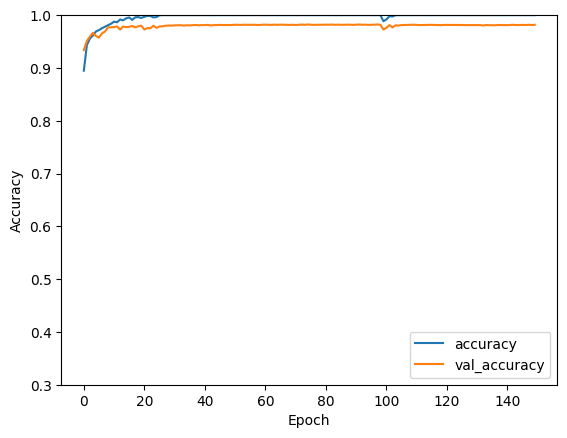

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 214ms/step
[[3.2547990e-14 2.7213135e-21 1.3369590e-30 1.0000000e+00]]
prediction: 3


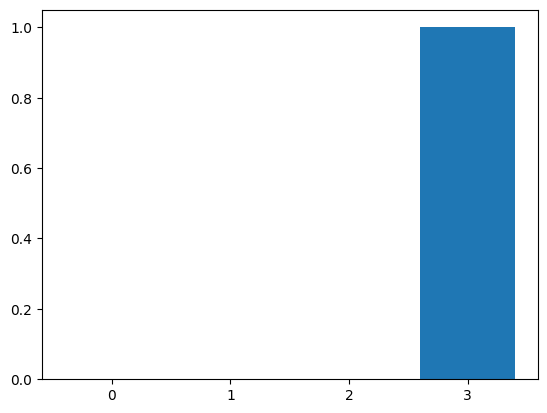

In [ ]:
# demonstration: predict the ith test digit
i = 11
prediction = model.predict(X_test[i].detach().cpu().numpy().reshape(1,28,28,3))

# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,4).astype('str'), prediction[0,:])
plt.show()

1/1 [==============================] - 0s 20ms/step


actual label: tensor(2, device='cuda:0')


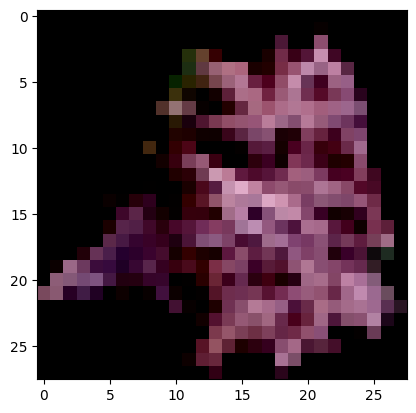

In [ ]:
# demonstration: predict the ith test digit

# Convert the PyTorch tensor to a NumPy array and reshape for prediction
prediction = model.predict(X_test[i].detach().cpu().numpy().reshape(1, 28, 28, 3))


# show the actual ith digit

print('actual label:', y_test[i])
plt.figure()
# Move the image tensor to CPU before displaying
plt.imshow(X_test[i].detach().cpu().permute(1, 2, 0))  # Move to CPU and permute dimensions
plt.show()

## Accuracy Score

In [ ]:
# Convert y_test to NumPy array and then to one-hot encoding
y_test_np = y_test.cpu().numpy()  # Move to CPU and convert to NumPy
y_test_one_hot = tf.keras.utils.to_categorical(y_test_np, num_classes=4)

In [ ]:
from sklearn.metrics import accuracy_score

pred_labels = model.predict(X_test_np).argmax(axis=1)
true_labels = y_test_one_hot.argmax(axis=1)

accuracy = accuracy_score(true_labels, pred_labels)
print(f"Test Accuracy: {accuracy:.2f}")




186/186 [==============================] - 0s 2ms/step
Test Accuracy: 0.98


In [ ]:
# Convert y_test to NumPy array and then to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_np, num_classes=4)

pred_labels_train = model.predict(X_train_np).argmax(axis=1)
true_labels_train = y_train_one_hot.argmax(axis=1)

train_accuracy = accuracy_score(true_labels_train, pred_labels_train)
print(f"Train Accuracy: {train_accuracy:.2f}")

742/742 [==============================] - 1s 2ms/step
Train Accuracy: 1.00


## Confusion Matrix

In [ ]:
confusion_mat = tf.math.confusion_matrix(labels=true_labels, predictions=pred_labels).numpy()
confusion_mat


array([[3133,   27,    0,   11],
       [  11,  646,    2,   26],
       [   0,    0,  619,    0],
       [  14,   18,    0, 1425]], dtype=int32)

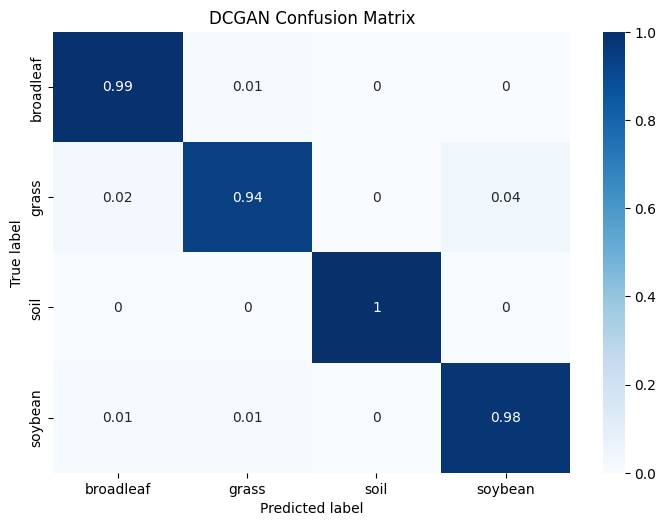

In [ ]:
import pandas as pd
import seaborn as sns

index_to_label = {index: label for label, index in label_to_index.items()}

# normalize
confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)

# classes = np.arange(0,4).astype('str')
valid_indices = [i for i in range(len(labels)) if i in index_to_label]
classes = [index_to_label[i] for i in valid_indices]

# classes = [index_to_label[i] for i in range(len(labels))]
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes,
                                columns = classes)

# generate heatmap
figure = plt.figure(figsize=(7, 5))
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('DCGAN Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Save the figure
output_path = '/content/drive/MyDrive/Colab Notebooks/Dissertation/figures/DCGAN_confusion_matrix.png'
plt.savefig(output_path)
plt.show()

## F1 Score

- 'micro' for calculating a global F1 score or None to get the F1 score for each class separately. Choose the appropriate average based on your specific requirements.


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# Assuming pred_labels and true_labels are NumPy arrays from TensorFlow

# Calculate F1 Score (Macro Average)
f1_macro = f1_score(true_labels, pred_labels, average='macro')
print(f"Macro F1 Score: {f1_macro}")

# Calculate F1 Score (Weighted Average)
f1_weighted = f1_score(true_labels, pred_labels, average='weighted')
print(f"Weighted F1 Score: {f1_weighted}")
# print(classification_report(true_labels, pred_labels, target_names=labels))

Macro F1 Score: 0.9759370434249339
Weighted F1 Score: 0.9816552841965862


186/186 [==============================] - 0s 2ms/step


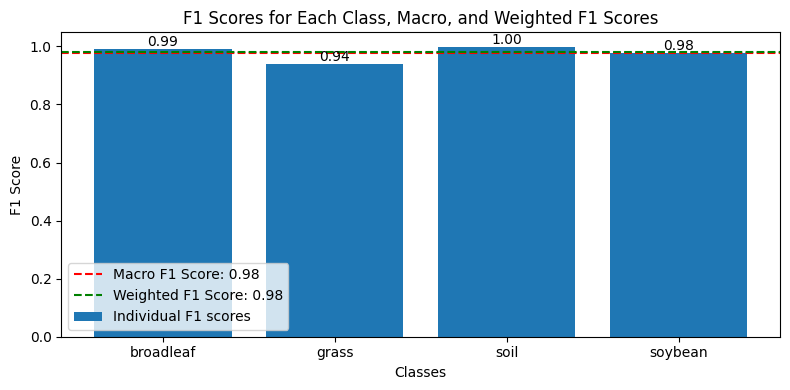

In [ ]:
from sklearn.metrics import f1_score

# Assuming y_test_np and pred_labels are the true and predicted labels respectively
true_labels = y_test_one_hot.argmax(axis=1)
pred_labels = model.predict(X_test_np).argmax(axis=1)

# Calculate F1 scores
f1_scores = f1_score(true_labels, pred_labels, average=None)
macro_f1 = f1_score(true_labels, pred_labels, average='macro')
weighted_f1 = f1_score(true_labels, pred_labels, average='weighted')


# Use actual class names
index_to_label = {index: label for label, index in label_to_index.items()}
valid_indices = [i for i in range(len(labels)) if i in index_to_label]
classes = [index_to_label[i] for i in valid_indices]

# Create bar graph
fig, ax = plt.subplots(figsize=(8, 4))

# Plot individual F1 scores
bars = ax.bar(classes, f1_scores, label='Individual F1 scores')

# Plot macro and weighted F1 scores
ax.axhline(macro_f1, color='r', linestyle='--', label=f'Macro F1 Score: {macro_f1:.2f}')
ax.axhline(weighted_f1, color='g', linestyle='--', label=f'Weighted F1 Score: {weighted_f1:.2f}')

# Annotate bars with F1 scores
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Add labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores for Each Class, Macro, and Weighted F1 Scores')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

## Classification report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3171
           1       0.93      0.94      0.94       685
           2       1.00      1.00      1.00       619
           3       0.97      0.98      0.98      1457

    accuracy                           0.98      5932
   macro avg       0.97      0.98      0.98      5932
weighted avg       0.98      0.98      0.98      5932



<Figure size 700x500 with 0 Axes>

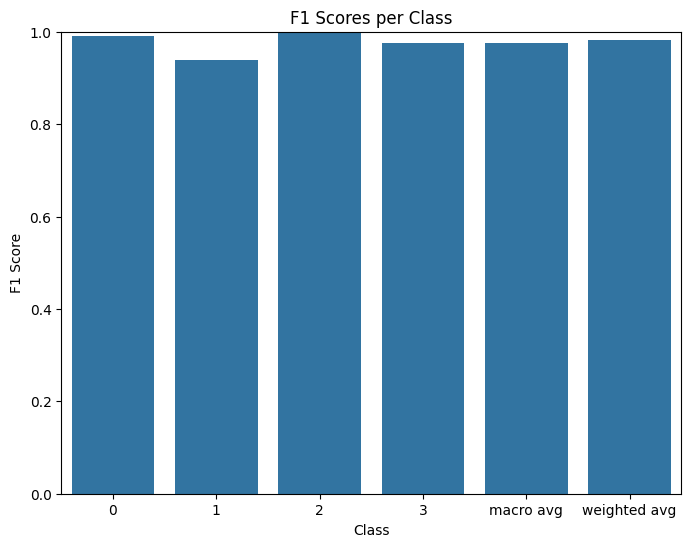

Plot saved to /content/drive/MyDrive/Colab Notebooks/Dissertation/figures/classification_report_f1_scores.png


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Extract F1 scores
f1_scores = report_df.loc[:, "f1-score"].drop(['accuracy'])
figure = plt.figure(figsize=(7, 5))

# Plot the F1 scores
plt.figure(figsize=(8, 6))
sns.barplot(x=f1_scores.index, y=f1_scores.values)
plt.title('F1 Scores per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()

# Save the plot to Google Drive
output_path = '/content/drive/MyDrive/Colab Notebooks/Dissertation/figures/classification_report_f1_scores.png'
plt.savefig(output_path)
print(f"Plot saved to {output_path}")

## AUC ROC

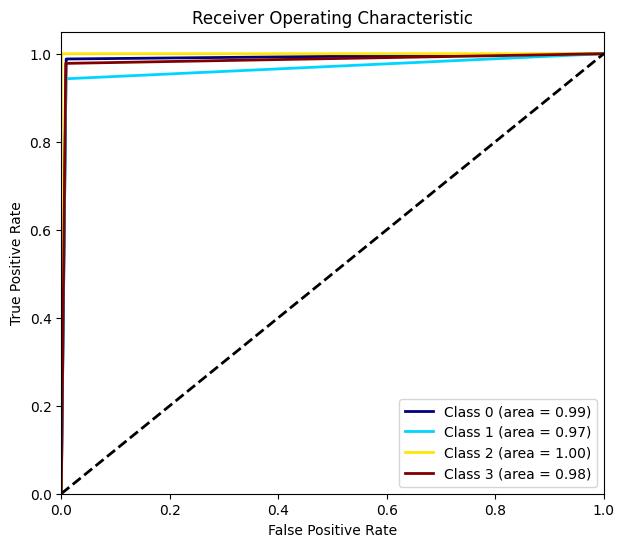

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

# Binarize the output
conf_matrix = confusion_matrix(true_labels, pred_labels)
y_test_bin = label_binarize(true_labels, classes=np.arange(len(conf_matrix)))
y_pred_bin = label_binarize(pred_labels, classes=np.arange(len(conf_matrix)))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(7, 6))
colors = plt.cm.jet(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()